# Poem Summarization Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip show pytorch-lightning

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 16.8 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from transformers import AdamW, BertForSequenceClassification, BertTokenizerFast as BertTokenizer
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path

import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/final year project /poem summarization /Dataset/poemsum_train.csv',encoding='utf8')
valid_df = pd.read_csv('/content/drive/MyDrive/final year project /poem summarization /Dataset/poemsum_valid.csv',encoding='utf8')
test_df = pd.read_csv('/content/drive/MyDrive/final year project /poem summarization /Dataset/poemsum_test.csv',encoding='utf8')

In [ ]:
train_df.head()


,Title,Poet,text,ctext,Poem Link
0,Never Shall I Forget by Elie Wiesel,Elie Wiesel,Never Shall I Forget' by Elie Wiesel is a harr...,"Never shall I forget that night, the first nig...",https://www.hmd.org.uk/wp-content/uploads/2018...
1,Leap Before You Look by W. H. Auden,W.H. Auden,'Leap Before You Look' by W. H. Auden is all a...,The sense of danger must not disappear:\nThe w...,https://knopfdoubleday.com/2012/04/16/w-h-aude...
2,Joseph Jones by Owen Sheers,Owen Sheers,Joseph Jones is a character that Sheers explor...,Of course I remember Joseph\nFifty press-ups b...,https://genius.com/Owen-sheers-joseph-jones-an...
3,Love Songs In Age by Philip Larkin,Philip Larkin,'Love Songs in Age' is about a widow who accid...,"She kept her songs, they kept so little space,...",https://www.thepoetryhour.com/poems/love-songs...
4,Another Valentine by Wendy Cope,Wendy Cope,'Another Valentine' by Wendy Cope presents the...,Today we are obliged to be romantic\nAnd think...,https://emilyspoetryblog.com/wendy-cope/poems/...


In [ ]:
valid_df.head()

,Title,Poet,text,ctext,Poem Link
0,"Dear John, Dear Coltrane by Michael S. Harper",Michael S. Harper,"'Dear John, Dear Coltrane' by Michael S. Harpe...","a love supreme, a love supreme\na love supreme...",https://www.poetryfoundation.org/poems/42827/d...
1,Parrot by Stevie Smith,Stevie Smith,‘Parrot‘ depicts the declining health of a won...,The old sick green parrot\nHigh in a dingy cag...,https://revise.wales/pastPapers/A-level/Englis...
2,Dust of Snow by Robert Frost,Robert Frost,"The simplicity, in the end, is the key element...",The way a crow\nShook down on me\nThe dust of ...,https://www.poetryfoundation.org/poems/44262/d...
3,Suburban Sonnet by Gwen Harwood,Gwen Harwood,'Suburban Sonnet' by Gwen Harwood is a poem ab...,"She practises a fugue, though it can matter\nt...",https://genius.com/Gwen-harwood-suburban-sonne...
4,Unending Love by Rabindranath Tagore,Rabindranath Tagore,'Unending Love' by Rabindranath Tagore is a he...,"I seem to have loved you in numberless forms, ...",https://allpoetry.com/Unending-Love


In [ ]:
test_df.head()

,Title,Poet,text,ctext,Poem Link
0,Solitude by A.A. Milne,Alan Alexander Milne,Solitude' by A.A. Milne is a very simple poem ...,I have a house where I go\nWhen there's too ma...,https://allpoetry.com/poem/8518933-Solitude-by...
1,On My Boat on Lake Cayuga by William Cole,William Cole,'On My Boat on Lake Cayuga' by William Cole is...,On my boat on Lake Cayuga\nI have a horn that ...,https://poettreeyr.wordpress.com/2013/08/10/au...
2,On the Pulse of Morning by Maya Angelou,Maya Angelou,'On the Pulse of Morning' by Maya Angelou is a...,"A Rock, A River, A Tree\nHosts to species long...",https://poets.org/poem/pulse-morning
3,The Butterfly by Alice Freeman Palmer,Alice Freeman Palmer,'The Butterfly' by Alice Freeman Palmer is a s...,"I hold you at last in my hand,\nExquisite chil...",https://rainydaypoems.com/poems-for-kids/bug-p...
4,Casehistory: Alison (Head Injury) by U.A. Fant...,U.A. Fanthorpe,"In short form, Alison, the poem's speaker, is ...",(She looks at her photograph)\n\nI would like ...,https://genius.com/U-a-fanthorpe-casehistory-a...


In [ ]:
import re
import string


def clean_text(text):
    # Remove extra white spaces and new lines
    text = str(text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\n', ' ', text)
    # Remove non-alphanumeric and non-punctuation characters
    text = re.sub('[^a-zA-Z0-9\s{}]+'.format(re.escape(string.punctuation)), '', text)
    # Strip leading/trailing white spaces
    text = text.strip()
    return text

In [ ]:
train_df['cleaned_text'] = train_df['ctext'].apply(clean_text)
train_df['text'] = train_df['text'].apply(clean_text)
train_df['Title'] = train_df['Title'].apply(clean_text)

valid_df['cleaned_text'] = valid_df['ctext'].apply(clean_text)
valid_df['text'] = valid_df['text'].apply(clean_text)
valid_df['Title'] = valid_df['Title'].apply(clean_text)

test_df['cleaned_text'] = test_df['ctext'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
test_df['Title'] = test_df['Title'].apply(clean_text)

In [ ]:
def get_all(title,ctext):
    return title + " - " + ctext

train_df['poem'] = train_df.apply(lambda x: get_all(x.Title, x.cleaned_text), axis=1)
valid_df['poem'] = valid_df.apply(lambda x: get_all(x.Title, x.cleaned_text), axis=1)
test_df['poem'] = test_df.apply(lambda x: get_all(x.Title, x.cleaned_text), axis=1)

In [ ]:
train_df['cleaned_text'].iloc[0]

'Never shall I forget that night, the first night in camp, that turned my life into one long night seven times sealed. Never shall I forget that smoke. Never shall I forget the small faces of the children whose bodies I saw transformed into smoke under a silent sky. Never shall I forget those flames that consumed my faith for ever. Never shall I forget the nocturnal silence that deprived me for all eternity of the desire to live. Never shall I forget those moments that murdered my God and my soul and turned my dreams to ashes. Never shall I forget those things, even were I condemned to live as long as God Himself. Never'

In [ ]:
train_df['poem'].iloc[0]

'Never Shall I Forget by Elie Wiesel - Never shall I forget that night, the first night in camp, that turned my life into one long night seven times sealed. Never shall I forget that smoke. Never shall I forget the small faces of the children whose bodies I saw transformed into smoke under a silent sky. Never shall I forget those flames that consumed my faith for ever. Never shall I forget the nocturnal silence that deprived me for all eternity of the desire to live. Never shall I forget those moments that murdered my God and my soul and turned my dreams to ashes. Never shall I forget those things, even were I condemned to live as long as God Himself. Never'

In [ ]:
train_df = train_df[['text','poem']]
train_df.columns=["summary", "text"]
train_df=train_df.dropna()

valid_df = valid_df[['text','poem']]
valid_df.columns=["summary", "text"]
valid_df=valid_df.dropna()

test_df = test_df[['text','poem']]
test_df.columns=["summary", "text"]
test_df=test_df.dropna()

In [ ]:
train_df.head()

,summary,text
0,Never Shall I Forget' by Elie Wiesel is a harr...,Never Shall I Forget by Elie Wiesel - Never sh...
1,'Leap Before You Look' by W. H. Auden is all a...,Leap Before You Look by W. H. Auden - The sens...
2,Joseph Jones is a character that Sheers explor...,Joseph Jones by Owen Sheers - Of course I reme...
3,'Love Songs in Age' is about a widow who accid...,Love Songs In Age by Philip Larkin - She kept ...
4,'Another Valentine' by Wendy Cope presents the...,Another Valentine by Wendy Cope - Today we are...


In [ ]:
valid_df.head()

,summary,text
0,"'Dear John, Dear Coltrane' by Michael S. Harpe...","Dear John, Dear Coltrane by Michael S. Harper ..."
1,Parrot depicts the declining health of a wondr...,Parrot by Stevie Smith - The old sick green pa...
2,"The simplicity, in the end, is the key element...",Dust of Snow by Robert Frost - The way a crow ...
3,'Suburban Sonnet' by Gwen Harwood is a poem ab...,Suburban Sonnet by Gwen Harwood - She practise...
4,'Unending Love' by Rabindranath Tagore is a he...,Unending Love by Rabindranath Tagore - I seem ...


In [ ]:
class Tokenize_Dataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 256):

        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row["text"]

        text_encoding = tokenizer(data_row["text"],max_length=self.text_max_token_len,
                                 padding="max_length",
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")

        summary = data_row["summary"]
        summary_encoding = tokenizer(summary,max_length=self.summary_max_token_len,
                                 padding="max_length",
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")

        labels= summary_encoding["input_ids"]
        labels[labels == 0] = -100

        return dict(
            text=text,
            summary=summary,
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten())


In [ ]:
class Dataloader_Module(pl.LightningDataModule):
    def __init__(self,
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5Tokenizer,
                batch_size: int = 8,
                text_max_token_len: int = 512,
                summary_max_token_len: int = 256):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df

        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len= summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset =  Tokenize_Dataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset =  Tokenize_Dataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2)

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)



In [ ]:
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from transformers import BartTokenizerFast as BartTokenizer, BartForConditionalGeneration
from transformers import ProphetNetForConditionalGeneration, ProphetNetTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizerFast as PegasusTokenizer
from transformers import AutoTokenizer

MODEL_NAME = 't5-base'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 4

data_module = Dataloader_Module(train_df,valid_df,tokenizer,batch_size=BATCH_SIZE)

# Model T5



In [ ]:
class Pre_train_module(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, inputs_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(inputs_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask)
        return output.loss, output.logits

    def step(self, batch, batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self.forward(inputs_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_attention_mask=labels_attention_mask,
                             labels=labels)
        return loss, outputs

    def training_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)

        self.log("train_loss",loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("val_loss",loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("test_loss",loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)


In [ ]:
model_t5 = Pre_train_module()

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
from pytorch_lightning.callbacks.progress import ProgressBar

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="news-summary")

class LitProgressBar(ProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running validation ...')
        bar.refresh_rate = 30
        return bar

bar = LitProgressBar()

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator='gpu',  # Use 'gpu' for single GPU, 'ddp' for distributed training
)

# Set custom progress bar
trainer.callbacks.append(bar)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_t5,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 602: 'val_loss' reached 2.60626 (best 2.60626), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1204: 'val_loss' reached 2.57807 (best 2.57807), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1806: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
# Load the saved checkpoint
checkpoint_path = "/content/drive/MyDrive/Project Poem sumarization/trainer.ckpt"
# Load the checkpoint
device = torch.device('cpu')
checkpoint = torch.load(checkpoint_path, map_location=device)

# Adjust embedding sizes to match the checkpoint vocabulary size
model_state_dict = model_t5.state_dict()
for key in checkpoint['state_dict']:
    if key.startswith('model.shared') or key.startswith('model.encoder.embed_tokens') or key.startswith('model.decoder.embed_tokens'):
        model_state_dict[key] = checkpoint['state_dict'][key]


In [ ]:
trained_model = Pre_train_module.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [ ]:
def summarize_t5(text):
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move model and data to CUDA device if available
    trained_model.to(device)

    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
        ).to(device)

    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True)

    # Move generated IDs to CPU if CUDA is available
    generated_ids = generated_ids.cpu()

    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generated_ids
    ]
    return "".join(preds)


In [ ]:
title_poem = "The Phoenix and the Turtle"
author_name = "WILLIAM SHAKESPEARE"

heading = title_poem + " by " + author_name
# title + authore name



test_poem = """
Let the bird of loudest lay
On the sole Arabian tree
Herald sad and trumpet be,
To whose sound chaste wings obey.

But thou shrieking harbinger,
Foul precurrer of the fiend,
Augur of the fever's end,
To this troop come thou not near.

From this session interdict
Every fowl of tyrant wing,
Save the eagle, feather'd king;
Keep the obsequy so strict.

Let the priest in surplice white,
That defunctive music can,
Be the death-divining swan,
Lest the requiem lack his right.

And thou treble-dated crow,
That thy sable gender mak'st
With the breath thou giv'st and tak'st,
'Mongst our mourners shalt thou go.

Here the anthem doth commence:
Love and constancy is dead;
Phoenix and the Turtle fled
In a mutual flame from hence.

So they lov'd, as love in twain
Had the essence but in one;
Two distincts, division none:
Number there in love was slain.

Hearts remote, yet not asunder;
Distance and no space was seen
'Twixt this Turtle and his queen:
But in them it were a wonder.

So between them love did shine
That the Turtle saw his right
Flaming in the Phoenix' sight:
Either was the other's mine.

Property was thus appalled
That the self was not the same;
Single nature's double name
Neither two nor one was called.

Reason, in itself confounded,
Saw division grow together,
To themselves yet either neither,
Simple were so well compounded;

That it cried, "How true a twain
Seemeth this concordant one!
Love has reason, reason none,
If what parts can so remain."

Whereupon it made this threne
To the Phoenix and the Dove,
Co-supremes and stars of love,
As chorus to their tragic scene:

                 threnos

Beauty, truth, and rarity,
Grace in all simplicity,
Here enclos'd, in cinders lie.

Death is now the Phoenix' nest,
And the Turtle's loyal breast
To eternity doth rest,

Leaving no posterity:
'Twas not their infirmity,
It was married chastity.

Truth may seem but cannot be;
Beauty brag but 'tis not she;
Truth and beauty buried be.

To this urn let those repair
That are either true or fair;
For these dead birds sigh a prayer.
"""

test_text = get_all(clean_text(heading),clean_text(test_poem))
summary_test = summarize_t5(test_text)
print("Generated Summary by T5:")
print(summary_test)

Generated Summary by T5:
'The Phoenix and the Turtle' by WILLIAM SHAKESPEARE is a poem about two lovers, one of whom is a turtle. The poem begins with the speaker telling the reader that there should be an eagle on the tree and another bird on the trumpet. This bird is supposed to be a harbinger of the fiends coming to earth. It is also said to be a fowl of tyrant wing. In the second stanza, the speaker tells the listeners that they should keep their obsequiem so strict. They are not going to die in this way. There is no difference between the two creatures or the


#Generated Summary by T5:
'The Phoenix and the Turtle' by WILLIAM SHAKESPEARE is a beautiful poem that depicts two lovers, one of whom is a dove. The poem begins with the speaker stating that love is dead, but there is no reason to believe in it. It is only because of this fact that the poet has created a conflict between the two lovers. They are not related at all, they are just like each other. In the second stanza of the poem, the speaker tells the reader that their relationship was never going to be the same.

Generated Summary by T5:<br>

'The Phoenix and the Turtle' by WILLIAM SHAKESPEARE is a beautiful poem that depicts two lovers. The poet describes how one of the two loves, the Phoenix and the Turtle, fled from their home. They were in love, but there was a division between them. There was a conflict between the two, something that made it difficult for the poet to reconcile his feelings. In the second stanza, the poet begins by saying that the speaker should let the bird lay down on the tree with its trumpet. It should not be allowed to fly away from the troop coming near. He also asks that the gods keep the fowl of feather'd kings

In [ ]:
test_df_bart = test_df  # Testing for bart model

In [ ]:
test_df['pred'] = test_df['text'].apply(summarize_t5)

In [ ]:
test_df.to_csv('/content/drive/MyDrive/final year project /poem summarization /tested_data_T5.csv', index=False) #Enter name of the newly created predictions file in the quotes

In [ ]:
test_df.head()

,summary,text,pred
0,Solitude' by A.A. Milne is a very simple poem ...,Solitude by A.A. Milne - I have a house where ...,'Solitude' by A.A. Milne is a poem about a spe...
1,'On My Boat on Lake Cayuga' by William Cole is...,On My Boat on Lake Cayuga by William Cole - On...,'On My Boat on Lake Cayuga' by William Cole is...
2,'On the Pulse of Morning' by Maya Angelou is a...,On the Pulse of Morning by Maya Angelou - A Ro...,'On the Pulse of Morning' by Maya Angelou is a...
3,'The Butterfly' by Alice Freeman Palmer is a s...,The Butterfly by Alice Freeman Palmer - I hold...,'The Butterfly' by Alice Freeman Palmer is a b...
4,"In short form, Alison, the poem's speaker, is ...",Casehistory: Alison (Head Injury) by U.A. Fant...,'Casehistory: Alison (Head Injury)' by U.A. Fa...


###BART


In [ ]:
dataset = pd.concat([train_df, valid_df], ignore_index=True)

In [ ]:
dataset.head()

,summary,text
0,Never Shall I Forget' by Elie Wiesel is a harr...,Never Shall I Forget by Elie Wiesel - Never sh...
1,'Leap Before You Look' by W. H. Auden is all a...,Leap Before You Look by W. H. Auden - The sens...
2,Joseph Jones is a character that Sheers explor...,Joseph Jones by Owen Sheers - Of course I reme...
3,'Love Songs in Age' is about a widow who accid...,Love Songs In Age by Philip Larkin - She kept ...
4,'Another Valentine' by Wendy Cope presents the...,Another Valentine by Wendy Cope - Today we are...


In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define your dataset class
class PoemDataset(Dataset):
    def __init__(self, poems, summaries, tokenizer, max_length):
        self.poems = poems
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.poems)

    def __getitem__(self, idx):
        poem_text = self.poems[idx]
        summary_text = self.summaries[idx]

        inputs = self.tokenizer(poem_text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        labels = self.tokenizer(summary_text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze()
        }


In [ ]:
# Initialize tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
# Define hyperparameters
batch_size = 4
max_length = 512
num_epochs = 3

In [ ]:
# Create dataset and dataloader
dataset = PoemDataset(poems=dataset.text.tolist(), summaries=dataset.summary.tolist(), tokenizer=tokenizer, max_length=max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}')

In [ ]:
# Save or use the trained model for inference

torch.save(model.state_dict(), '/content/drive/MyDrive/Project Poem sumarization/bart_poem_summary_model.pth')

In [ ]:
# Load the trained model state dictionary
model_path = '/content/drive/MyDrive/Project Poem sumarization/bart_poem_summary_model.pth'
device = torch.device('cpu')
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

In [ ]:
# Function to generate summary for a poem
def generate_summary(poem_text, max_length=150):
    inputs = tokenizer(poem_text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    # Generate summary
    summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary_text


In [ ]:
# Example poem
poem = """
Let the bird of loudest lay
On the sole Arabian tree
Herald sad and trumpet be,
To whose sound chaste wings obey.

But thou shrieking harbinger,
Foul precurrer of the fiend,
Augur of the fever's end,
To this troop come thou not near.

From this session interdict
Every fowl of tyrant wing,
Save the eagle, feather'd king;
Keep the obsequy so strict.

Let the priest in surplice white,
That defunctive music can,
Be the death-divining swan,
Lest the requiem lack his right.

And thou treble-dated crow,
That thy sable gender mak'st
With the breath thou giv'st and tak'st,
'Mongst our mourners shalt thou go.

Here the anthem doth commence:
Love and constancy is dead;
Phoenix and the Turtle fled
In a mutual flame from hence.

So they lov'd, as love in twain
Had the essence but in one;
Two distincts, division none:
Number there in love was slain.

Hearts remote, yet not asunder;
Distance and no space was seen
'Twixt this Turtle and his queen:
But in them it were a wonder.

So between them love did shine
That the Turtle saw his right
Flaming in the Phoenix' sight:
Either was the other's mine.

Property was thus appalled
That the self was not the same;
Single nature's double name
Neither two nor one was called.

Reason, in itself confounded,
Saw division grow together,
To themselves yet either neither,
Simple were so well compounded;

That it cried, "How true a twain
Seemeth this concordant one!
Love has reason, reason none,
If what parts can so remain."

Whereupon it made this threne
To the Phoenix and the Dove,
Co-supremes and stars of love,
As chorus to their tragic scene:

                 threnos

Beauty, truth, and rarity,
Grace in all simplicity,
Here enclos'd, in cinders lie.

Death is now the Phoenix' nest,
And the Turtle's loyal breast
To eternity doth rest,

Leaving no posterity:
'Twas not their infirmity,
It was married chastity.

Truth may seem but cannot be;
Beauty brag but 'tis not she;
Truth and beauty buried be.

To this urn let those repair
That are either true or fair;
For these dead birds sigh a prayer.

"""

# Generate summary for the poem
generated_summary = generate_summary(poem)
print("Generated Summary by Bart:")
print(generated_summary)

#Generated Summary by Bart:

'Let the bird of loudest lay on the sole Arabian tree,' the speaker says. The bird is a bird that the speaker is trying to get rid of. He wants to rid of the bird and the bird. The speaker wants to remove the bird from the tree. It is the bird that he wants to be rid of, but he doesn't want to. He is unable to do so.

In [ ]:
test_df_bart['pred'] = test_df_bart['text'].apply(generate_summary)

In [ ]:
test_df_bart.to_csv('/content/drive/MyDrive/Project Poem sumarization/tested_data_bart.csv', index=False)

In [ ]:
test_df_bart.head()

,summary,text,pred
0,Solitude' by A.A. Milne is a very simple poem ...,Solitude by A.A. Milne - I have a house where ...,'Solitude' by A.A. Milne describes a speaker's...
1,'On My Boat on Lake Cayuga' by William Cole is...,On My Boat on Lake Cayuga by William Cole - On...,'On My Boat on Lake Cayuga' by William Cole de...
2,'On the Pulse of Morning' by Maya Angelou is a...,On the Pulse of Morning by Maya Angelou - A Ro...,'On the Pulse of Morning' by Maya Angelou is a...
3,'The Butterfly' by Alice Freeman Palmer is a s...,The Butterfly by Alice Freeman Palmer - I hold...,'The Butterfly' by Alice Freeman Palmer is a b...
4,"In short form, Alison, the poem's speaker, is ...",Casehistory: Alison (Head Injury) by U.A. Fant...,Casehistory: Alison (Head Injury) by U.A. Fant...


##Flan - T5

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
import pandas as pd

In [ ]:
# Initialize T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model_ft5 = T5ForConditionalGeneration.from_pretrained('t5-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load your poem summarization dataset
class PoemDataset(Dataset):
    def __init__(self, poems, summaries, tokenizer, max_length):
        self.poems = poems
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.poems)

    def __getitem__(self, idx):
        poem_text = self.poems[idx]
        summary_text = self.summaries[idx]

        inputs = self.tokenizer(poem_text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        labels = self.tokenizer(summary_text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze()
        }

In [ ]:
# Define hyperparameters
batch_size = 4
max_length = 512
num_epochs = 3

In [ ]:
# Define dataset and dataloader
train_dataset = pd.concat([train_df, valid_df], ignore_index=True)
train_dataset = PoemDataset(poems=train_dataset.text.tolist(), summaries=train_dataset.summary.tolist(), tokenizer=tokenizer, max_length=max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft5.to(device)
# Training loop
model_ft5.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_ft5(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}')

Epoch 1/3, Avg Loss: 14.1687
Epoch 2/3, Avg Loss: 14.1702
Epoch 3/3, Avg Loss: 14.1686


In [ ]:
# Save the fine-tuned model

torch.save(model_ft5.state_dict(), '/content/drive/MyDrive/Project Poem sumarization/ft5_poem_summary_model.pth')


In [ ]:
# Function to generate summary for a poem
def generate_summary_ft5(poem_text, max_length=150):
    inputs = tokenizer(poem_text, return_tensors='pt', max_length=max_lenght, truncation=True, padding='max_length')
    input_ids = inputs['input_ids'].to(model_ft5.device)
    attention_mask = inputs['attention_mask'].to(model_ft5.device)

    # Generate summary
    summary_ids = model_ft5.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary_text

In [ ]:
# Example poem
poem = """
Let the bird of loudest lay
On the sole Arabian tree
Herald sad and trumpet be,
To whose sound chaste wings obey.

But thou shrieking harbinger,
Foul precurrer of the fiend,
Augur of the fever's end,
To this troop come thou not near.

From this session interdict
Every fowl of tyrant wing,
Save the eagle, feather'd king;
Keep the obsequy so strict.

Let the priest in surplice white,
That defunctive music can,
Be the death-divining swan,
Lest the requiem lack his right.

And thou treble-dated crow,
That thy sable gender mak'st
With the breath thou giv'st and tak'st,
'Mongst our mourners shalt thou go.

Here the anthem doth commence:
Love and constancy is dead;
Phoenix and the Turtle fled
In a mutual flame from hence.

So they lov'd, as love in twain
Had the essence but in one;
Two distincts, division none:
Number there in love was slain.

Hearts remote, yet not asunder;
Distance and no space was seen
'Twixt this Turtle and his queen:
But in them it were a wonder.

So between them love did shine
That the Turtle saw his right
Flaming in the Phoenix' sight:
Either was the other's mine.

Property was thus appalled
That the self was not the same;
Single nature's double name
Neither two nor one was called.

Reason, in itself confounded,
Saw division grow together,
To themselves yet either neither,
Simple were so well compounded;

That it cried, "How true a twain
Seemeth this concordant one!
Love has reason, reason none,
If what parts can so remain."

Whereupon it made this threne
To the Phoenix and the Dove,
Co-supremes and stars of love,
As chorus to their tragic scene:

                 threnos

Beauty, truth, and rarity,
Grace in all simplicity,
Here enclos'd, in cinders lie.

Death is now the Phoenix' nest,
And the Turtle's loyal breast
To eternity doth rest,

Leaving no posterity:
'Twas not their infirmity,
It was married chastity.

Truth may seem but cannot be;
Beauty brag but 'tis not she;
Truth and beauty buried be.

To this urn let those repair
That are either true or fair;
For these dead birds sigh a prayer.

"""

# Generate summary for the poem
generated_summary_ft5 = generate_summary_ft5(poem)
print("Generated Summary by FLAN-T5 :")
print(generated_summary_ft5)

Generated Summary by FLAN-T5 :
tak'st and tak'st With the breath thou giv'st and tak'st With the breath thou giv'st and tak'st With the breath tak'st and tak'st With the breath tak'st and tak'st With the breath thou giv'st and tak'st With the breath thou


Generated Summary by FLAN-T5 :
tak'st and tak'st With the breath thou giv'st and tak'st With the breath thou giv'st and tak'st With the breath tak'st and tak'st With the breath tak'st and tak'st With the breath thou giv'st and tak'st With the breath thou

##GPT

In [ ]:
!pip install torch==1.9.0


In [ ]:
!pip install transformers
!pip install pytorch-lightning

In [ ]:
# Install necessary modules
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, LightningDataModule, LightningModule
from torch.nn import functional as F

In [ ]:
# Define the GPT2 tokenizer and model
tokenizer_gpt = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt = GPT2LMHeadModel.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Add a padding token to the tokenizer
tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
# Define the dataset class
class PoemDataset(Dataset):
    def __init__(self, poems, tokenizer_gpt, max_length):
        self.poems = poems
        self.tokenizer = tokenizer_gpt
        self.max_length = max_length

    def __len__(self):
        return len(self.poems)

    def __getitem__(self, idx):
        poem_text = self.poems[idx]
        input_ids = self.tokenizer.encode(poem_text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
        return input_ids

In [ ]:
# Define the data module
class PoemDataModule(pl.LightningDataModule):
    def __init__(self, train_df, valid_df, tokenizer_gpt, batch_size=1, max_length=512):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.batch_size = batch_size
        self.tokenizer_gpt = tokenizer_gpt
        self.max_length = max_length

    def setup(self, stage=None):
        self.train_dataset = PoemDataset(self.train_df['text'].tolist(), self.tokenizer_gpt, self.max_length)
        self.valid_dataset = PoemDataset(self.valid_df['text'].tolist(), self.tokenizer_gpt, self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size)

In [ ]:

# Initialize the data module
data_module = PoemDataModule(train_df, valid_df, tokenizer_gpt)

In [ ]:
# Define the Lightning module
class PoemModel(pl.LightningModule):
    def __init__(self, model_gpt):
        super().__init__()
        self.model = model_gpt

    def forward(self, input_ids, **kwargs):
        return self.model(input_ids, **kwargs)

    def training_step(self, batch, batch_idx):
        input_ids = batch.squeeze(1)
        labels = input_ids.clone()
        labels[labels == tokenizer_gpt.pad_token_id] = -100
        outputs = self(input_ids, labels=labels)
        loss = outputs.loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch.squeeze(1)
        labels = input_ids.clone()
        labels[labels == tokenizer_gpt.pad_token_id] = -100
        outputs = self(input_ids, labels=labels)
        loss = outputs.loss
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)

In [ ]:
# Initialize the model
model_gpt = PoemModel(model_gpt)

# Initialize the trainer
trainer = pl.Trainer(accelerator='gpu', max_epochs=3)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(model_gpt, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | PoemModel | 124 M 
------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
497.759   Total estimated model params size (MB)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/final year project /poem summarization /gpt_poem_model.pth')


In [ ]:
# Function to generate summary for a poem
def generate_summary_gpt(poem_text, max_length=150):
    inputs = tokenizer(poem_text, return_tensors='pt', max_length=max_lenght, truncation=True, padding='max_length')
    input_ids = inputs['input_ids'].to(model_gpt.device)
    attention_mask = inputs['attention_mask'].to(model_ft5.device)

    # Generate summary
    summary_ids = model_gpt.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)
    summary_text = tokenizer_gpt.decode(summary_ids[0], skip_special_tokens=True)

    return summary_text

In [ ]:
# Example poem
poem = """
Let the bird of loudest lay
On the sole Arabian tree
Herald sad and trumpet be,
To whose sound chaste wings obey.

But thou shrieking harbinger,
Foul precurrer of the fiend,
Augur of the fever's end,
To this troop come thou not near.

From this session interdict
Every fowl of tyrant wing,
Save the eagle, feather'd king;
Keep the obsequy so strict.

Let the priest in surplice white,
That defunctive music can,
Be the death-divining swan,
Lest the requiem lack his right.

And thou treble-dated crow,
That thy sable gender mak'st
With the breath thou giv'st and tak'st,
'Mongst our mourners shalt thou go.

Here the anthem doth commence:
Love and constancy is dead;
Phoenix and the Turtle fled
In a mutual flame from hence.

So they lov'd, as love in twain
Had the essence but in one;
Two distincts, division none:
Number there in love was slain.

Hearts remote, yet not asunder;
Distance and no space was seen
'Twixt this Turtle and his queen:
But in them it were a wonder.

So between them love did shine
That the Turtle saw his right
Flaming in the Phoenix' sight:
Either was the other's mine.

Property was thus appalled
That the self was not the same;
Single nature's double name
Neither two nor one was called.

Reason, in itself confounded,
Saw division grow together,
To themselves yet either neither,
Simple were so well compounded;

That it cried, "How true a twain
Seemeth this concordant one!
Love has reason, reason none,
If what parts can so remain."

Whereupon it made this threne
To the Phoenix and the Dove,
Co-supremes and stars of love,
As chorus to their tragic scene:

                 threnos

Beauty, truth, and rarity,
Grace in all simplicity,
Here enclos'd, in cinders lie.

Death is now the Phoenix' nest,
And the Turtle's loyal breast
To eternity doth rest,

Leaving no posterity:
'Twas not their infirmity,
It was married chastity.

Truth may seem but cannot be;
Beauty brag but 'tis not she;
Truth and beauty buried be.

To this urn let those repair
That are either true or fair;
For these dead birds sigh a prayer.

"""

# Generate summary for the poem
generated_summary_gpt = generate_summary_gpt(poem)
print("Generated Summary by GPT :")
print(generated_summary_gpt)

##Analysis


In [ ]:
!pip install rouge

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
from rouge import Rouge
from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df['summary'].tolist(), df['pred'].tolist()

def compute_rouge_scores(references, hypotheses):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

def compute_bleu_scores(references, hypotheses):
    references_tokenized = [[ref.split()] for ref in references]
    hypotheses_tokenized = [hyp.split() for hyp in hypotheses]
    bleu_scores = corpus_bleu(references_tokenized, hypotheses_tokenized)
    return bleu_scores

def compute_meteor_scores(references, hypotheses):
    meteor_scores = []
    for ref, hyp in zip(references, hypotheses):
        ref_tokens = word_tokenize(ref)
        hyp_tokens = word_tokenize(hyp)
        score = meteor_score.single_meteor_score(ref_tokens, hyp_tokens)
        meteor_scores.append(score)

    avg_meteor_score = sum(meteor_scores) / len(meteor_scores)
    return avg_meteor_score

# Load test data for T5 and BART models
t5_references, t5_hypotheses = load_data('/content/drive/MyDrive/final year Project /Poem sumarization/tested data/tested_data_T5.csv')
bart_references, bart_hypotheses = load_data('/content/drive/MyDrive/final year Project /Poem sumarization/tested data/tested_data_bart.csv')

# Compute scores for T5 model
t5_rouge_scores = compute_rouge_scores(t5_references, t5_hypotheses)
t5_bleu_scores = compute_bleu_scores(t5_references, t5_hypotheses)
t5_meteor_score = compute_meteor_scores(t5_references, t5_hypotheses)

# Compute scores for BART model
bart_rouge_scores = compute_rouge_scores(bart_references, bart_hypotheses)
bart_bleu_scores = compute_bleu_scores(bart_references, bart_hypotheses)
bart_meteor_score = compute_meteor_scores(bart_references, bart_hypotheses)

# Print or visualize the scores to compare the performance
print("T5 ROUGE Scores:", t5_rouge_scores)
print("T5 BLEU Score:", t5_bleu_scores)
print("T5 METEOR Score:", t5_meteor_score)

print("BART ROUGE Scores:", bart_rouge_scores)
print("BART BLEU Score:", bart_bleu_scores)
print("BART METEOR Score:", bart_meteor_score)


T5 ROUGE Scores: {'rouge-1': {'r': 0.3240820072843638, 'p': 0.39020175172926574, 'f': 0.34687580257383654}, 'rouge-2': {'r': 0.0969083144882351, 'p': 0.1291419925465447, 'f': 0.10774841738843276}, 'rouge-l': {'r': 0.29831709546015145, 'p': 0.3594263272109088, 'f': 0.3194125747918539}}
T5 BLEU Score: 0.0685840142287486
T5 METEOR Score: 0.25633641783317546
BART ROUGE Scores: {'rouge-1': {'r': 0.28721717249710554, 'p': 0.39641892818512703, 'f': 0.32531557239289716}, 'rouge-2': {'r': 0.1024492823043018, 'p': 0.13709308831285524, 'f': 0.11371051933193317}, 'rouge-l': {'r': 0.2682146810701315, 'p': 0.3709847432002051, 'f': 0.30417623576093394}}
BART BLEU Score: 0.07355651977289154
BART METEOR Score: 0.25695188017759546


#T5

T5 ROUGE Scores: {'rouge-1': {'r': 0.31335711198639205, 'p': 0.3991870960714197, 'f': 0.3446741334950146}, <br>
'rouge-2': {'r': 0.09384697447107969, 'p': 0.13425590913110996, 'f': 0.1078126399438623}, <br>
'rouge-l': {'r': 0.28870299078854483, 'p': 0.3679965909269755, 'f': 0.31761688395807386}} <br>
T5 BLEU Score: 0.06636918967092466 <br>
T5 METEOR Score: 0.25184644585377675 <br>
#BART

BART ROUGE Scores: {'rouge-1': {'r': 0.28721717249710554, 'p': 0.39641892818512703, 'f': 0.32531557239289716}, <br>
'rouge-2': {'r': 0.1024492823043018, 'p': 0.13709308831285524, 'f': 0.11371051933193317},<br>
'rouge-l': {'r': 0.2682146810701315, 'p': 0.3709847432002051, 'f': 0.30417623576093394}}<br>
BART BLEU Score: 0.07355651977289154<br>
BART METEOR Score: 0.25695188017759546

Graphical representation

In [ ]:
print(t5_rouge_scores)

{'rouge-1': {'r': 0.3240820072843638, 'p': 0.39020175172926574, 'f': 0.34687580257383654}, 'rouge-2': {'r': 0.0969083144882351, 'p': 0.1291419925465447, 'f': 0.10774841738843276}, 'rouge-l': {'r': 0.29831709546015145, 'p': 0.3594263272109088, 'f': 0.3194125747918539}}


In [ ]:
t5_f1_scores = {
    'rouge-1': 2 * (t5_rouge_scores['rouge-1']['r'] * t5_rouge_scores['rouge-1']['p']) /
               (t5_rouge_scores['rouge-1']['r'] + t5_rouge_scores['rouge-1']['p']),
    'rouge-2': 2 * (t5_rouge_scores['rouge-2']['r'] * t5_rouge_scores['rouge-2']['p']) /
               (t5_rouge_scores['rouge-2']['r'] + t5_rouge_scores['rouge-2']['p']),
    'rouge-l': 2 * (t5_rouge_scores['rouge-l']['r'] * t5_rouge_scores['rouge-l']['p']) /
               (t5_rouge_scores['rouge-l']['r'] + t5_rouge_scores['rouge-l']['p'])
}
print(t5_f1_scores)

{'rouge-1': 0.35408159670583367, 'rouge-2': 0.11072697039435861, 'rouge-l': 0.32603296139409943}


In [ ]:
bart_f1_scores = {
    'rouge-1': 2 * (bart_rouge_scores['rouge-1']['r'] * bart_rouge_scores['rouge-1']['p']) /
               (bart_rouge_scores['rouge-1']['r'] + bart_rouge_scores['rouge-1']['p']),
    'rouge-2': 2 * (bart_rouge_scores['rouge-2']['r'] * bart_rouge_scores['rouge-2']['p']) /
               (bart_rouge_scores['rouge-2']['r'] + bart_rouge_scores['rouge-2']['p']),
    'rouge-l': 2 * (bart_rouge_scores['rouge-l']['r'] * bart_rouge_scores['rouge-l']['p']) /
               (bart_rouge_scores['rouge-l']['r'] + bart_rouge_scores['rouge-l']['p'])
}
print(bart_f1_scores)



{'rouge-1': 0.33309628781757067, 'rouge-2': 0.11726600576212477, 'rouge-l': 0.31133806070903036}


In [ ]:
# ROUGE scores for T5 and BART models

# Function to calculate average F1 score
def calculate_average_f1(rouge_scores):
    rouge_1_f1 = rouge_scores['rouge-1']['f']
    rouge_2_f1 = rouge_scores['rouge-2']['f']
    rouge_l_f1 = rouge_scores['rouge-l']['f']

    average_f1 = (rouge_1_f1 + rouge_2_f1 + rouge_l_f1) / 3
    return average_f1

# Calculate average F1 scores for T5 and BART models
t5_average_f1 = calculate_average_f1(t5_rouge_scores)
bart_average_f1 = calculate_average_f1(bart_rouge_scores)

print("T5 Average F1 Score:", t5_average_f1)
print("BART Average F1 Score:", bart_average_f1)


T5 Average F1 Score: 0.2580122649180411
BART Average F1 Score: 0.2477341091619214


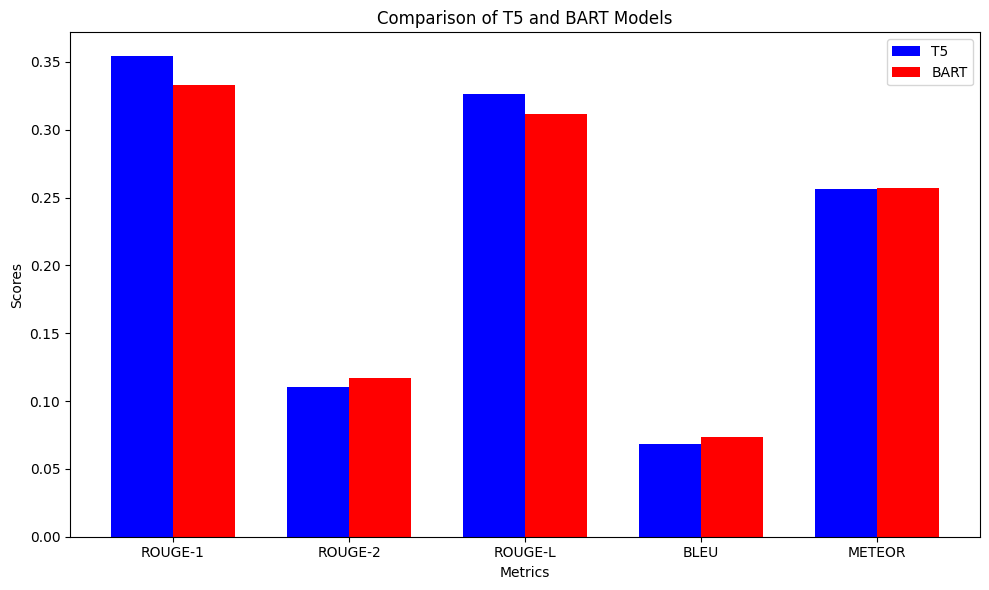

In [ ]:
import matplotlib.pyplot as plt


t5_scores = t5_f1_scores
bart_scores = bart_f1_scores

# Define metrics and corresponding scores for both models
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR']
t5_scores = [t5_scores['rouge-1'], t5_scores['rouge-2'], t5_scores['rouge-l'], t5_bleu_scores, t5_meteor_score]
bart_scores = [bart_scores['rouge-1'], bart_scores['rouge-2'], bart_scores['rouge-l'], bart_bleu_scores, bart_meteor_score]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(metrics))
bar_width = 0.35

# Plot T5 scores
t5_bars = ax.bar(index, t5_scores, bar_width, label='T5', color='b')

# Plot BART scores
bart_bars = ax.bar([p + bar_width for p in index], bart_scores, bar_width, label='BART', color='r')

# Add labels, title, and ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of T5 and BART Models')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


